# Machine Learning Lab Project - Credit Card Overdue Likelihood Prediction

##  Business Understanding

It is important for banks to know in advance whether or not a customer will repay their credit card bill on time in order to decide whether or not to give them a credit card. To do this, they try to make a prediction based on personal information. Therefore, they compare the current customer with historical data from other customers.

Because credit scoring is a very complex task, it is very difficult to find a well performing model. An other problem is that a transparent and comprehensible model should be used so that customers understand the bank's decision. To find such a model is really hard in the world of machine learning algorithms.

Then you have to decide how to tackle the problem. Do you try to calculate an exact percentage using regression or do you try to classify the customer and assign them to a probability class?

## Data Understanding
The data for this task is taken from [this](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction) kaggle dataset. The kaggle page provides two `.csv` files:
- application_record.csv
- credit_record.csv

On a simple level, `application_record.csv` contains the customer data and `credit_record.csv` contains the customers credit history. The specific content is now investigated further.

For beeing able to analyse the datasets, the necessary libraries are imported first:

In [155]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text
import matplotlib.pyplot as plt

In this next step the two `.csv` files are loaded into a pandas datafram. This enables an analysis with the full pandas funcionality, which makes the data understanding process way easier.

In [156]:
customer_df = pd.read_csv("Data/application_record.csv")
credit_df = pd.read_csv("Data/credit_record.csv")

### application_record.csv
First, it is important to analyse the columns of the dataset:

In [157]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

As can be seen above, the dataset consists of 17 columns, containing numeral as well as textual data. It also seems as if there is already an unique identifier for every customer in the column `ID`. A concrete description fo these different columns can be retrieved from the datasets [kaggle page](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data):

|Feature name|Explanation|Remarks|
|:-----------|:----------|:------|
|ID 	     |Client number||
|CODE_GENDER |	Gender 	||
|FLAG_OWN_CAR| 	Is there a car 	||
|FLAG_OWN_REALTY| 	Is there a property|| 	
|CNT_CHILDREN| 	Number of children 	||
|AMT_INCOME_TOTAL| 	Annual income 	||
|NAME_INCOME_TYPE| 	Income category 	||
|NAME_EDUCATION_TYPE| 	Education level ||	
|NAME_FAMILY_STATUS| 	Marital status 	||
|NAME_HOUSING_TYPE| 	Way of living 	||
|DAYS_BIRTH| 	Birthday |	Count backwards from current day (0), -1 means yesterday|
|DAYS_EMPLOYED| 	Start date of employment |	Count backwards from current day(0). If positive, it means the person currently  unemployed.|
|FLAG_MOBIL| 	Is there a mobile phone 	||
|FLAG_WORK_PHONE| 	Is there a work phone 	||
|FLAG_PHONE| 	Is there a phone 	||
|FLAG_EMAIL| 	Is there an email 	||
|OCCUPATION_TYPE| 	Occupation 	||
|CNT_FAM_MEMBERS| 	Family size||

Now that the purpose of the columns is clear, the actual data can be analyzed:

In [158]:
customer_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


From these first five entries several things can be observed:
1. The ID does not start from 0 but seems to be unique.
2. For the `CODE_GENDER` the flags `F` (Female) and `M` (Male) are used.
3. For `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` the flags `Y` (Yes) and `N` (No) are used.
4. For `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS` and `NAME_HOUSING_TYPE` are textual fields, but seem to have only a few different values.
5. `OCCUPATION_TYPE` is a textual field and the values seem to be very different ("Freetext Field").
6. For `FLAG_MOBIL`, `FLAG_WORK_PHONE`, `FLAG_PHONE` and `FLAG_EMAIL` the flags 1 (Yes) and 0 (No) are used.

Before basing the data perparation on these findings, the assumptions have to be validated:

#### 1. Unique `ID`

In [159]:
customer_df['ID'].value_counts()

ID
7137299    2
7702238    2
7282535    2
7243768    2
7050948    2
          ..
5690727    1
6621262    1
6621261    1
6621260    1
6842885    1
Name: count, Length: 438510, dtype: int64

The ouptut of the value count clearly shows that not every ID is unique. As some IDs are contained twice, the real amout of customers contained in the dataset is only 438510.
#### 2. Gender

In [160]:
customer_df['CODE_GENDER'].value_counts()

CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64

For the gender the assumption that only the flags `F` and `M` are used was correct.
#### 3. Flag Car / Real-Estate

In [161]:
print(customer_df['FLAG_OWN_CAR'].value_counts())
print(customer_df['FLAG_OWN_REALTY'].value_counts())

FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64
FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64


Also for the flags for the possesion of car and real-estate the assumption that there are only the flags `Y` and `N` was correct.
#### 4. Text fields income, education, family and housing

In [162]:
customer_df['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64

As can be seen above, there are five different types of income. This means the column can be encoded without any problems and can be used for the modeling later.

In [163]:
customer_df['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64

The education field also consists of only five types and can therefore also be used for modelling without any problems.

In [164]:
customer_df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: int64

Also the family status has five different values.

In [165]:
customer_df['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: count, dtype: int64

The housing has six different values, which is still acceptable.
#### 5. Text field occupation type

In [166]:
print(customer_df['OCCUPATION_TYPE'].value_counts())
print("Amount of null values: ", customer_df['OCCUPATION_TYPE'].isnull().sum())

OCCUPATION_TYPE
Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: count, dtype: int64
Amount of null values:  134203


Even though there are way less different values than expected (only 18), the column contains many null values, which may make it difficult to work with it.
#### 6. Contact method flags

In [167]:
print(customer_df['FLAG_MOBIL'].value_counts())
print(customer_df['FLAG_WORK_PHONE'].value_counts())
print(customer_df['FLAG_PHONE'].value_counts())
print(customer_df['FLAG_EMAIL'].value_counts())

FLAG_MOBIL
1    438557
Name: count, dtype: int64
FLAG_WORK_PHONE
0    348156
1     90401
Name: count, dtype: int64
FLAG_PHONE
0    312353
1    126204
Name: count, dtype: int64
FLAG_EMAIL
0    391102
1     47455
Name: count, dtype: int64


As expected, these columns only use the flags `1` and `0`. On top of that, column `FLAG_MOBIL` only contains the value `1`, which means all customers at least are registered with a mobile phone. Therefore, this column can be left out completely.
### credit_record.csv
Again, first analyze the columns:

In [168]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


As can be seen above, this table only contains three columns. According to the [kaggle page](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data), these columns mean the following:

|Feature name| 	Explanation |	Remarks|
|:-|:-|:-|
|ID |	Client number 	||
|MONTHS_BALANCE |	Record month |	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on|
|STATUS |	Status| 	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month|

Checking for unique `ID` values now reveals for how many customers there exists credit data:

In [169]:
len(credit_df['ID'].unique())

45985

There is only credit data for 45985 customers, that means only parts of the `customer_df` can be used.
As a last step check the values of the `STATUS` column:

In [170]:
credit_df['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

The information given on the kaggle page is correct, only the stated flags are used.
### Summary
Overall, the dataset consists of two parts: the customer data and the credit data. The customer data mostly contains information about income, job, family situation and contact methods as these are important aspects for evaluating the creditworthiness. The credit data is basically a credit history overview, showing for a given custumer and month if the credit was paid back on time. This credit data can now be used for calculating an "overdue_likelyhood" for every customer which states how likely it is for this specific customer to not pay it's credit back in time. This is an important information for a credit institute. Based on all the findings in this section the two datasets can now be prepared, connected and finally used for training a machine learning model.

## Data Preparation

First, the credit data must be brought into a format that the classifiers can work with. Therefore a new feature the "overdue likelihood" is calculated. For every customer,the amount of credits that were not paid back on time is devided by the total amount of it's credits. This gives a percentage how likely it is for each customer to not pay back on time.

In [171]:
grouped_df = credit_df.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)
grouped_df['overdue_likelihood'] = 1 - (grouped_df['C'] / (grouped_df.sum(axis=1) - grouped_df['X']))

result_df = grouped_df.reset_index()[['ID', 'overdue_likelihood']]
print(result_df.head())


STATUS       ID  overdue_likelihood
0       5001711            1.000000
1       5001712            0.526316
2       5001713                 NaN
3       5001714                 NaN
4       5001715                 NaN


As there are customers that don't have any credits at all (leads to division by zero which is forbidden), the new features contain some "NaN" values:

In [172]:
nan_count = result_df['overdue_likelihood'].isna().sum()
print(f'The number of entries with NaN values in overdue_likelihood: {nan_count}')

The number of entries with NaN values in overdue_likelihood: 4536


As we can't use the NaN values in a reasonable way, they have to be removed, leaving us with ca. 33110 usable customers.

In [173]:
result_df.dropna(subset=['overdue_likelihood'], inplace=True)
nan_count = result_df['overdue_likelihood'].isna().sum()

print(f'The number of entries with NaN values in overdue_likelihood: {nan_count}')

The number of entries with NaN values in overdue_likelihood: 0


Finally, the two dataframes have to be connected, so the classifiers can use one single, merged dataframe.

In [174]:
merged_df = pd.merge(customer_df, result_df, on='ID', how='inner')
print(merged_df.head())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008810           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

As the dataframe already has a large amout of columns, some columns that are not too important should be dropped to reduce the data complexiti. The following tables are only about contact information and can therefore be ignored:

In [175]:
merged_df = merged_df.drop('FLAG_MOBIL', axis=1)
merged_df = merged_df.drop('FLAG_WORK_PHONE', axis=1)
merged_df = merged_df.drop('FLAG_PHONE', axis=1)
merged_df = merged_df.drop('FLAG_EMAIL', axis=1)

As already mentioned in the data understanding, the occupation type has to many different values, and can therefore also not be used. Also the ID is not necessary anymore as the two dataframes are already merged.

In [176]:
merged_df = merged_df.drop('OCCUPATION_TYPE', axis=1)
merged_df = merged_df.drop('ID', axis=1)

Whats left is to encode the features, so that in the end only numerical values are contained. Therefore all columns with only two different values are ordinal encoded and all other columns are one hot encoded.

In [177]:
one_hot_cols = ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_EDUCATION_TYPE']
ordinal_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


df_ord = merged_df.copy()
ordinal_encoder = OrdinalEncoder()
df_ord[ordinal_cols] = ordinal_encoder.fit_transform(df_ord[ordinal_cols])

df_enc = pd.get_dummies(df_ord, columns=one_hot_cols)

print(df_enc.head())

   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0          1.0           1.0              1.0             0          427500.0   
1          1.0           1.0              1.0             0          427500.0   
2          1.0           1.0              1.0             0          112500.0   
3          0.0           0.0              1.0             0          270000.0   
4          0.0           0.0              1.0             0          270000.0   

   DAYS_BIRTH  DAYS_EMPLOYED  CNT_FAM_MEMBERS  overdue_likelihood  \
0      -12005          -4542              2.0            0.133333   
1      -12005          -4542              2.0            0.142857   
2      -21474          -1134              2.0            0.500000   
3      -19110          -3051              1.0            1.000000   
4      -19110          -3051              1.0            0.285714   

   NAME_INCOME_TYPE_Commercial associate  ...  \
0                                  False  ...   


## Modeling

For the modelling we chose a Desicion Tree and KNN for classification and Ridge regression to evaluate different techniques for this specific dataset.

### Desicion Tree

For a decision tree we need class labels that will be predicted. Therefore a new feature "overdue_class" is created based on the overdue likelyhood. As the dataset is very unbalanced, the class threshold is chosen in a way that both classes have an comparable amount of values.

In [178]:
df_enc['overdue_class'] = pd.qcut(df_enc['overdue_likelihood'], q=2, labels=['1', '2'])

Now that the target feature is present, we can seperate X and Y:

In [179]:
X_enc = df_enc.drop('overdue_class', axis=1)
X_enc = X_enc.drop('overdue_likelihood', axis=1)
Y = df_enc['overdue_class']

As the last step before training, the data has to be scaled:

In [180]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)
df_scaled = pd.DataFrame(X_scaled, columns= X_enc.columns)

Now, the data can be split into test and training data and then the model can be trained.

In [181]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, Y, test_size=0.3, random_state=42)

In [182]:
clf = DecisionTreeClassifier(random_state=42)

clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('accurary:', accuracy_score(y_test, y_pred))

accurary: 0.6572032618544247


Now train another tree with a fixed depth of five, as the tree above is most likely overfitted.

In [183]:
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('accurary:', accuracy_score(y_test, y_pred))

accurary: 0.5313601127554616


Unfortunately the tree seems to  be just 3% better than guessing...

The advantage of the desicion tree is that we can have a look at the desicions that are taken before a class is assigned. As can be seen from the following plot, the most important feature seems to be the days since a customer is employed, as it is used very often to make a desicion.

In [184]:
r = export_text(clf, feature_names=X_test.columns)
print(r)

|--- DAYS_EMPLOYED <= -0.45
|   |--- AMT_INCOME_TOTAL <= 2.80
|   |   |--- DAYS_EMPLOYED <= -0.46
|   |   |   |--- DAYS_BIRTH <= 0.99
|   |   |   |   |--- DAYS_EMPLOYED <= -0.46
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- DAYS_EMPLOYED >  -0.46
|   |   |   |   |   |--- class: 2
|   |   |   |--- DAYS_BIRTH >  0.99
|   |   |   |   |--- CNT_CHILDREN <= 0.10
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- CNT_CHILDREN >  0.10
|   |   |   |   |   |--- class: 1
|   |   |--- DAYS_EMPLOYED >  -0.46
|   |   |   |--- DAYS_BIRTH <= -1.89
|   |   |   |   |--- CODE_GENDER <= 0.36
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- CODE_GENDER >  0.36
|   |   |   |   |   |--- class: 2
|   |   |   |--- DAYS_BIRTH >  -1.89
|   |   |   |   |--- DAYS_BIRTH <= 1.49
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- DAYS_BIRTH >  1.49
|   |   |   |   |   |--- class: 2
|   |--- AMT_INCOME_TOTAL >  2.80
|   |   |--- NAME_HOUSING_TYPE_Rented apartment <= 3.83
|   |   |   |--- DAYS_EM

### KNN
As the third classifier, KNN is used. Like for the desicion tree a class label must be generated first. This time we use three different classes, each representing a third of the complete likelihood range.

In [185]:
bins = [0, 0.33, 0.66, 1]
labels = ['1', '2', '3']

df_enc['overdue_class'] = pd.cut(df_enc['overdue_likelihood'], bins=bins, labels=labels, include_lowest=True)
df_enc['overdue_class'].value_counts()

overdue_class
3    17650
1     9784
2     5676
Name: count, dtype: int64

As the class label is created, the data can be split into x and y again:

In [186]:
X_enc = df_enc.drop('overdue_class', axis=1)
X_enc = X_enc.drop('overdue_likelihood', axis=1)
Y = df_enc['overdue_class']

Before training the model, the data is scaled again:

In [187]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)
df_scaled = pd.DataFrame(X_scaled, columns= X_enc.columns)

X_train, X_test, y_train, y_test = train_test_split(df_scaled, Y, test_size=0.3, random_state=42)

Finally, the model is trained:

In [188]:
rf_classifier = KNeighborsClassifier(n_neighbors=20, metric = 'euclidean', weights='distance')

rf_classifier.fit(X_train, y_train)
y_test_pred = rf_classifier.predict(X_test.values)

accuracy = accuracy_score(y_test, y_test_pred)
print(accuracy)

C:\Users\mj0st\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.5660928219067753


### Regression
Another approach would be trying to directly predict the overdue likelyhood.

Again, we have to seperate X and Y but this time using "overdue_likelihood" as our target:

In [189]:
X_enc = df_enc.drop('overdue_class', axis=1)
X_enc = X_enc.drop('overdue_likelihood', axis=1)
Y = df_enc['overdue_likelihood']

Also, the data has to be scaled again before it can be split into test and training data:

In [190]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)
df_scaled = pd.DataFrame(X_scaled, columns= X_enc.columns)

X_train, X_test, y_train, y_test = train_test_split(df_scaled, Y, test_size=0.3, random_state=42)

Now, the regressor can be trained:

In [191]:
ridge_reg = Ridge()

ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.1377380459425281


A nice way would be to plot the predicted value next to the actual values, to get a visual representation of the results:

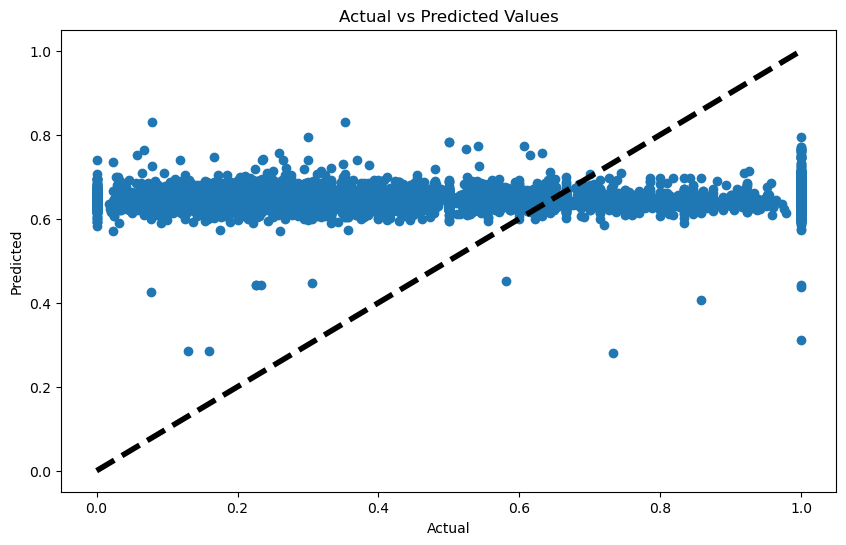

In [192]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()


Obviously, the result of the regression is even worse than the one of the desicion tree classification, as of course predicting a certain number is way more complex than just predicting a class which represents a whole range of values.

The KNN classifier seems to achive a comparable good result, as simply guessing would lead to an accuracy of 33%, which is clearly lower than the classifiers accuracy of 56%.

## Neural Network

The last model tested is a regression neural network. It is more of a testbed to check if a resonably well regression estimation can be made from the given dataset. Due to the amount of required code and training time (~1h), it was moved to a separate notebook. Let's go through its specifications.

### Data preparation differences and Data augmentation
First, the data preparation phase differs slightly. Due to the immense complexity of the problem, it showed that it is best to use all data for training. This includes things like the one-hot encoded Occupation type which leads to a input layer size of a 53 dimensional vector. Furthermore, our data is very unbalanced. One of the main problems with this is the strong bias towards an overdue likelihood of 1.0. To balance the data, it showed that upsampling works well with the Neural Network. The biased 1.0 data is first cut down to arround the a less biased amount arround 2000 samples down from 20 000. This introduces the new problem of too little data. Using upsampling might help solves this, going from arround 19 000 samples to 1 000 000 samples. While this is not as good as real data, using the synthetic data works a bit better then not using it. To help training and break up possible unwanted patterns, the additionally generated data is randomized slightly.

### Data correlation
When working with the data, it appeared that the data only has minor correlation between the overdue_likelihood and the different features. This is also the reason why the previously mentioned models performed very bad, even at binary classification. In the neural network, we can use the correlation factors to our advantage:

```
[1000000 rows x 53 columns]
CODE_GENDER                                          0.048031
FLAG_OWN_CAR                                         0.590612
FLAG_OWN_REALTY                                      0.612433
CNT_CHILDREN                                         0.346236
AMT_INCOME_TOTAL                                     0.066008
DAYS_BIRTH                                           0.094416
DAYS_EMPLOYED                                        0.002161
FLAG_MOBIL                                           0.024534
FLAG_WORK_PHONE                                      0.032219
FLAG_PHONE                                           0.185193
FLAG_EMAIL                                           0.295898
CNT_FAM_MEMBERS                                      0.254827
NAME_EDUCATION_TYPE_Academic degree                  0.228687
NAME_EDUCATION_TYPE_Higher education                 0.181573
NAME_EDUCATION_TYPE_Incomplete higher                0.059953
NAME_EDUCATION_TYPE_Lower secondary                  0.686017
NAME_EDUCATION_TYPE_Secondary / secondary special    0.306015
NAME_FAMILY_STATUS_Civil marriage                    0.237519
NAME_FAMILY_STATUS_Married                           0.108516
NAME_FAMILY_STATUS_Separated                         0.251201
NAME_FAMILY_STATUS_Single / not married              0.112105
NAME_FAMILY_STATUS_Widow                             0.408784
NAME_INCOME_TYPE_Commercial associate                0.545801
NAME_INCOME_TYPE_Pensioner                           0.003140
NAME_INCOME_TYPE_State servant                       0.149918
NAME_INCOME_TYPE_Student                             0.263440
NAME_INCOME_TYPE_Working                             0.372770
NAME_HOUSING_TYPE_Co-op apartment                    0.252179
NAME_HOUSING_TYPE_House / apartment                  0.834754
NAME_HOUSING_TYPE_Municipal apartment                0.002506
NAME_HOUSING_TYPE_Office apartment                   0.117364
NAME_HOUSING_TYPE_Rented apartment                   0.224839
NAME_HOUSING_TYPE_With parents                       1.000000
OCCUPATION_TYPE_Accountants                          0.586541
OCCUPATION_TYPE_Cleaning staff                       0.286565
OCCUPATION_TYPE_Cooking staff                        0.526278
OCCUPATION_TYPE_Core staff                           0.489603
OCCUPATION_TYPE_Drivers                              0.083598
OCCUPATION_TYPE_HR staff                             0.112035
OCCUPATION_TYPE_High skill tech staff                0.527586
OCCUPATION_TYPE_IT staff                             0.172765
OCCUPATION_TYPE_Laborers                             0.414626
OCCUPATION_TYPE_Low-skill Laborers                   0.449379
OCCUPATION_TYPE_Managers                             0.530295
OCCUPATION_TYPE_Medicine staff                       0.330640
OCCUPATION_TYPE_NaN                                  0.073581
OCCUPATION_TYPE_Private service staff                0.146233
OCCUPATION_TYPE_Realty agents                        0.452292
OCCUPATION_TYPE_Sales staff                          0.891669
OCCUPATION_TYPE_Secretaries                          0.010655
OCCUPATION_TYPE_Security staff                       0.215127
OCCUPATION_TYPE_Waiters/barmen staff                 0.064129
```
This displays the relative correlation between the different features. The values are normalized and are generally much smaller.

### Model architecture
Before training the model and tuning the hyper-parameters, the model architecture has to be defined. This model is a simple feedforward neural network with an additional linear layer between the input and hidden layers. This linear layer weights the input data based on their correlation with the target value (overdue_likelihood). The input and linear layers both contain 53 neurons to take all data features in.
The 4 deep layers following contain 2048 neurons each, rendering them very large. Empirically, it could be obseverved that the model struggles from underfitting, but increasing the parameters even more results in much longer training time with minor benefit. The Output layer contains of a single neuron.

The activation function used for the hidden layers is a standard ReLU function which proved to be the best. As the model is comparatively large, it is a good choice to fight vanishing gradients. Due to the underfitting, using dropout layers proved to have negative effect on the convergence. For the output neuron, several functions were tested. The sigmoid function proved to be optimal as the output should be in the range of 0 to 1. Other functions like ReLU or the normally used linear activation (no function) just lowered the achieved accuracy.

For the loss function, several were tested as well. The overall best choice was surprisingly the Mean Absolute Error (MAE). While it creates stronger outliers then MSE, they are very sparse and the general accuracy is better.

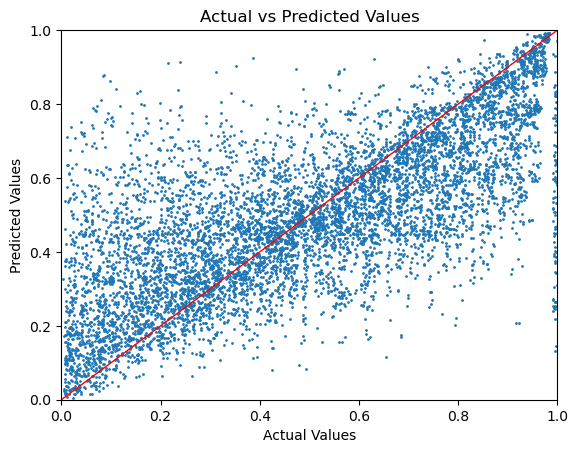
MSE used in training.


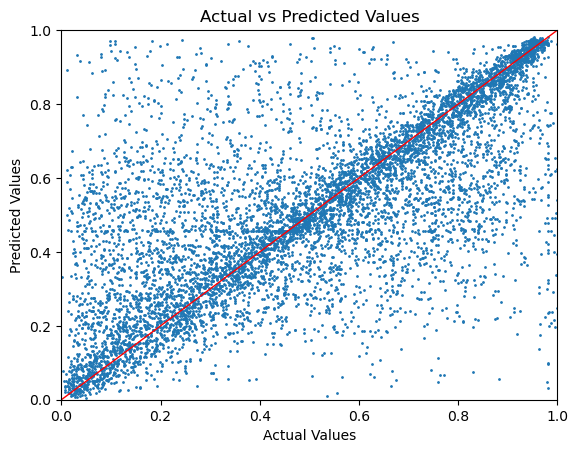
MAE used in training.


### Training

Training the model proved to be very tricky, as there are a lot of hyperparameters to tune and the training time is quite lengthy (arround 1h with CUDA acceleration). A batch size of 64 was used, which increases the training size even further given the 1 000 000 sized data. The learning rate is a standard 0.0025. 
The model achieved a good 11.5% average error given the result from other models tested and the very inconsistent dataset.


### Considerations on the optimization

While this models performance looks good on paper, it is very likely that it suffers from some sort of "hidden" overfitting. As there are a lot of nearly duplicate values, it is likely that the model is very specialized on these cases. While it is able to distinguish between the existing data very well, generalization might be very hard, given the sparsity of the data.

As the test set contains a lot of duplicates, it achieves a better performance then it should.

When using the inital dataset, the output becomes way worse. Due to the very thin data avialability for the higher overdue_likelihood data, the predictions are pretty much guessing. Interestingly, when there is higher data density, the model gets at least somewhat accurate, leading to an average error higher then in the model training on the "stuffed" data.

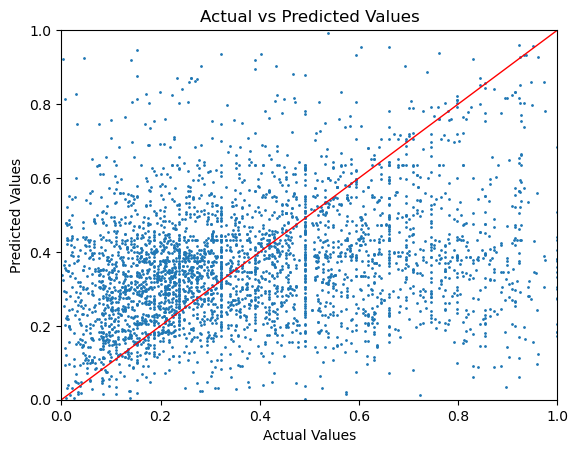
MSE loss used in training without any synthetic data this yields about 17% average error.

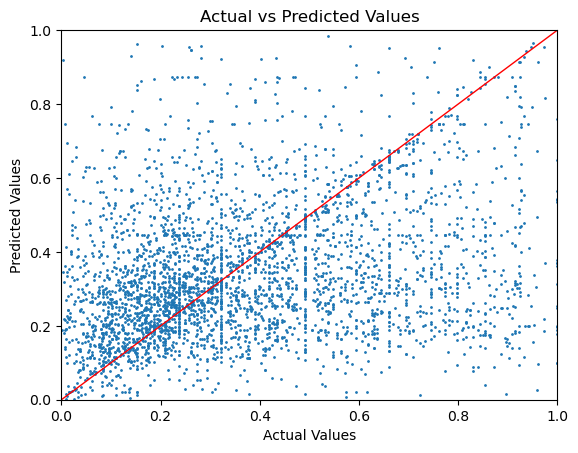
MAE used with otherwise identical parameters. This yields about 12% accuracy, but seems to be equally bad in general due to strong outliers. 



## Evaluation

As seen before, the correlation is very low in our dataset. This, and the very high complexity of the given task, classification as well as regression (even more), makes it very hards to make any predictions based on the given data. The dataset is simply too small, especially for a regression, even for a "deep" neural network. 

The decision to calculate a "overdue likelihood" might be also a bad one as the data does provide information on how long and if customers paid off their debt, which we do not use as information. However, as this adds aditional depth to the data, it might make things even worse.
Possibly, a better approach could be defining a threshold for each customer and classify if the customer will pay back their debt in that timeframe or at all. A good threshold could be an overdue likelihood of 1 vs everything else, based on how the data is spread out.